<a href="https://colab.research.google.com/github/yuvalira/Monet_style_transfer/blob/main/data/EDA_monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA — Monet Style Transfer Project**

**Dataset: [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)**

The dataset contains two unpaired image domains stored in **TFRecord** format:

- **Monet-style paintings** (`monet_tfrec`)
- **Real-world landscape photos** (`photo_tfrec`)

Each image is stored as a **256×256×3** tensor.  
Our goal is to translate real photos into Monet-style paintings.

---

The preprocessing and EDA in this notebook include:

1. **Downloading** the dataset from Kaggle.  
2. **Loading** Monet and Photo datasets from TFRecords.  
3. **EDA and visualization**, including:  
   - Counting dataset shards and total image records.  
   - Inspecting image shapes and pixel value ranges.  
   - Displaying side-by-side samples from both domains.  
   - Showing random grids of images from each domain.  
   - Plotting pixel value histograms.

## 1. Setup

In [1]:
!pip install "tensorflow==2.15.*" "keras==2.15.*" "tensorflow-estimator==2.15.*" "numpy<1.27"
!pip install "tensorflow-addons==0.22.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


Import dependencies

In [7]:
# Standard library
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

Configure Kaggle API access

In [3]:
!pip -q install kaggle

import os, json
from google.colab import files

print("Please upload your kaggle.json (from https://www.kaggle.com/settings/account)")
uploaded = files.upload()  # choose kaggle.json
assert "kaggle.json" in uploaded, "kaggle.json is required."

os.makedirs("/root/.kaggle", exist_ok=True)
with open("kaggle.json", "r") as f:
    creds = json.load(f)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(creds, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle API is configured.")

Please upload your kaggle.json (from https://www.kaggle.com/settings/account)


Saving kaggle.json to kaggle.json
Kaggle API is configured.


## 2. Load Dataset



In [4]:
# Download the competition bundle
!kaggle competitions download -c gan-getting-started -p ./kaggle -q

# Unzip the main archive into ./kaggle
!unzip -q ./kaggle/gan-getting-started.zip -d ./kaggle

# Create target folders for TFRecords
!mkdir -p ./tfrecords/monet_tfrec ./tfrecords/photo_tfrec

# Some competitions bundle TFRecords inside their own zip files.
# Try to unzip monet_tfrec and photo_tfrec zips if they exist:
!if [ -f ./kaggle/monet_tfrec.zip ]; then unzip -q ./kaggle/monet_tfrec.zip -d ./tfrecords/monet_tfrec; fi
!if [ -f ./kaggle/photo_tfrec.zip ]; then unzip -q ./kaggle/photo_tfrec.zip -d ./tfrecords/photo_tfrec; fi

# If TFRecords were extracted as folders under ./kaggle (not zipped),
# copy them into the standard structure:
!if [ -d ./kaggle/monet_tfrec ]; then cp -r ./kaggle/monet_tfrec/* ./tfrecords/monet_tfrec/; fi
!if [ -d ./kaggle/photo_tfrec ]; then cp -r ./kaggle/photo_tfrec/* ./tfrecords/photo_tfrec/; fi

# Verify
import glob, os
monet_tfrec = glob.glob("./tfrecords/monet_tfrec/*.tfrec")
photo_tfrec = glob.glob("./tfrecords/photo_tfrec/*.tfrec")
print("Monet TFRecord shards:", len(monet_tfrec))
print("Photo TFRecord shards:", len(photo_tfrec))
assert len(monet_tfrec) > 0 and len(photo_tfrec) > 0, "TFRecord files not found. Check unzip paths."

Monet TFRecord shards: 5
Photo TFRecord shards: 20


## 3. Dataset EDA

Monet images: 300
Photo images: 7038
Example image shape: (256, 256, 3)
Value range : -1.0 to 1.0


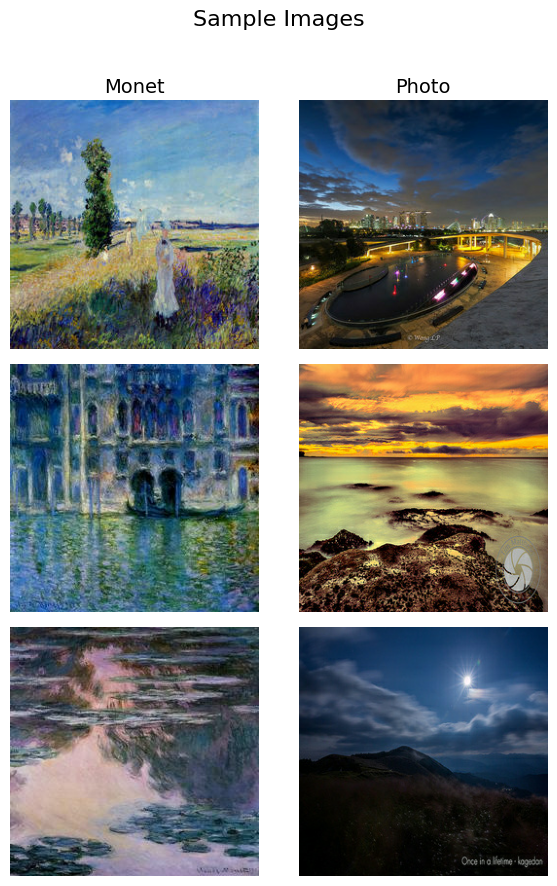

[Photo] 25165824 pixels → mean=-0.1887, std=0.5547, min=-1.000, max=1.000
[Monet] 25165824 pixels → mean=0.0121, std=0.4741, min=-1.000, max=1.000


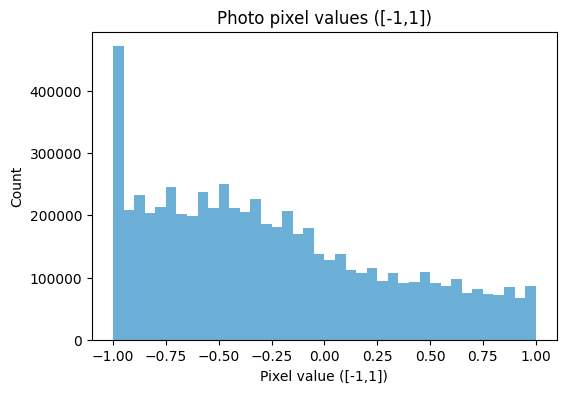

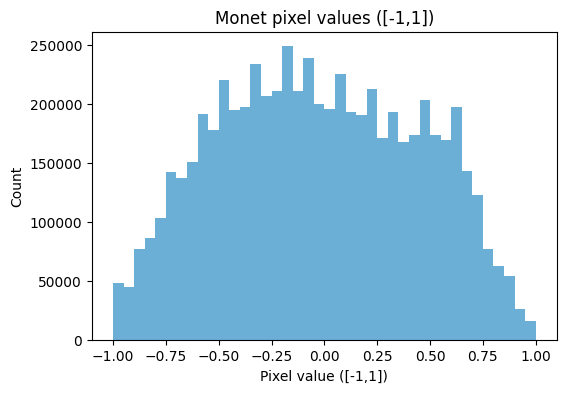

In [9]:
# Config
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (256, 256)
MONET_DIR = "./tfrecords/monet_tfrec"
PHOTO_DIR = "./tfrecords/photo_tfrec"

# TFRecord parsing
_TFREC_FEATURES = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.string),
}

def _decode_image(image_bytes: tf.Tensor) -> tf.Tensor:
    img = tf.image.decode_jpeg(image_bytes, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 127.5 - 1.0   # [-1, 1]
    return img

def _parse_image_only(example: tf.Tensor) -> tf.Tensor:
    ex = tf.io.parse_single_example(example, _TFREC_FEATURES)
    return _decode_image(ex["image"])

def load_domain(domain_dir: str) -> tf.data.Dataset:
    files = tf.io.gfile.glob(f"{domain_dir}/*.tfrec")
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.map(_parse_image_only, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

def count_records(domain_dir: str) -> int:
    files = tf.io.gfile.glob(f"{domain_dir}/*.tfrec")
    return sum(1 for _ in tf.data.TFRecordDataset(files))

# Visualization helpers
def _to_list(ds, k=50):
    return list(ds.take(k))

def show_monet_photo_pairs(monet_ds, photo_ds, n_examples=3, seed=42,
                           left_title="Monet", right_title="Photo"):
    random.seed(seed)
    monet_samples = _to_list(monet_ds, 50)
    photo_samples = _to_list(photo_ds, 50)
    monet_pick = random.sample(monet_samples, n_examples)
    photo_pick = random.sample(photo_samples, n_examples)
    pairs = list(zip(monet_pick, photo_pick))

    fig, axes = plt.subplots(n_examples, 2, figsize=(6, 3 * n_examples))
    fig.suptitle("Sample Images", fontsize=16)
    for i, (monet_img, photo_img) in enumerate(pairs):
        for col, (img, title) in enumerate([(monet_img, left_title), (photo_img, right_title)]):
            if isinstance(img, (tuple, list)): img = img[0]
            if len(img.shape) == 4: img = img[0]
            img_show = ((img + 1.0) * 0.5).numpy()  # [-1,1] -> [0,1]
            axes[i, col].imshow(np.clip(img_show, 0, 1))
            axes[i, col].axis("off")
            if i == 0: axes[i, col].set_title(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

def pixel_stats(ds, k=128, name="dataset"):
    vals = []
    for img in ds.take(k):
        if isinstance(img, (tuple, list)): img = img[0]
        if len(img.shape) == 4: img = img[0]
        vals.append(img.numpy().ravel())
    vals = np.concatenate(vals)
    print(f"[{name}] {vals.size} pixels → mean={vals.mean():.4f}, std={vals.std():.4f}, "
          f"min={vals.min():.3f}, max={vals.max():.3f}")

def show_histogram(ds, k=16, bins=40, title="Pixel value histogram"):
    vals = []
    for img in ds.take(k):
        if isinstance(img, (tuple, list)): img = img[0]
        if len(img.shape) == 4: img = img[0]
        vals.append(img.numpy().ravel())
    vals = np.concatenate(vals)
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=bins, color="#6baed6")
    plt.title(title); plt.xlabel("Pixel value ([-1,1])"); plt.ylabel("Count")
    plt.show()

# Load datasets
monet_ds = load_domain(MONET_DIR)
photo_ds = load_domain(PHOTO_DIR)

# Counts & sanity check
print(f"Monet images: {count_records(MONET_DIR)}")
print(f"Photo images: {count_records(PHOTO_DIR)}")

ex_img = next(iter(monet_ds.take(1))).numpy()
print("Example image shape:", ex_img.shape)
print("Value range :", float(ex_img.min()), "to", float(ex_img.max()))

# Visuals & stats
show_monet_photo_pairs(monet_ds, photo_ds, n_examples=3)
pixel_stats(photo_ds,  k=128, name="Photo")
pixel_stats(monet_ds, k=128, name="Monet")
show_histogram(photo_ds,  k=32, title="Photo pixel values ([-1,1])")
show_histogram(monet_ds, k=32, title="Monet pixel values ([-1,1])")

## 4. Channel Matching Preprocessing (Photo → Monet)

**What we do.**

Before training, we apply a **deterministic, per-channel normalization** that shifts Photo images to have the **same RGB mean and standard deviation** as the Monet domain. Images remain in the range $[-1, 1]$; content is unchanged.

**Why we do it.**

* **Reduce domain gap** in global tone/contrast so the generator can focus on style/texture rather than fixing brightness/contrast.
* **Stabilize training** and often **speed up convergence**.

**How it works (per channel R, G, B).**
We compute means/stds on the *training* sets:

* Photo: $\mu_{\mathrm{P}}, \sigma_{\mathrm{P}}$
* Monet: $\mu_{\mathrm{M}}, \sigma_{\mathrm{M}}$

Then we transform each photo pixel $x$ by:

$$
y \;=\; (x - \mu_{\mathrm{P}})\cdot\frac{\sigma_{\mathrm{M}}}{\sigma_{\mathrm{P}}} \;+\; \mu_{\mathrm{M}}
$$

and clip to $[-1, 1]$. This is done independently for **R/G/B**.

Photo  mean/std: [-0.19313778 -0.18294269 -0.23451823] [0.54403895 0.4993832  0.55620515]
Monet  mean/std: [ 0.04302527  0.04860228 -0.04654266] [0.4560396  0.4402793  0.49411553]
Channel-match scale: [0.8382481 0.8816462 0.8883692] shift: [0.20492265 0.20989302 0.16179611]


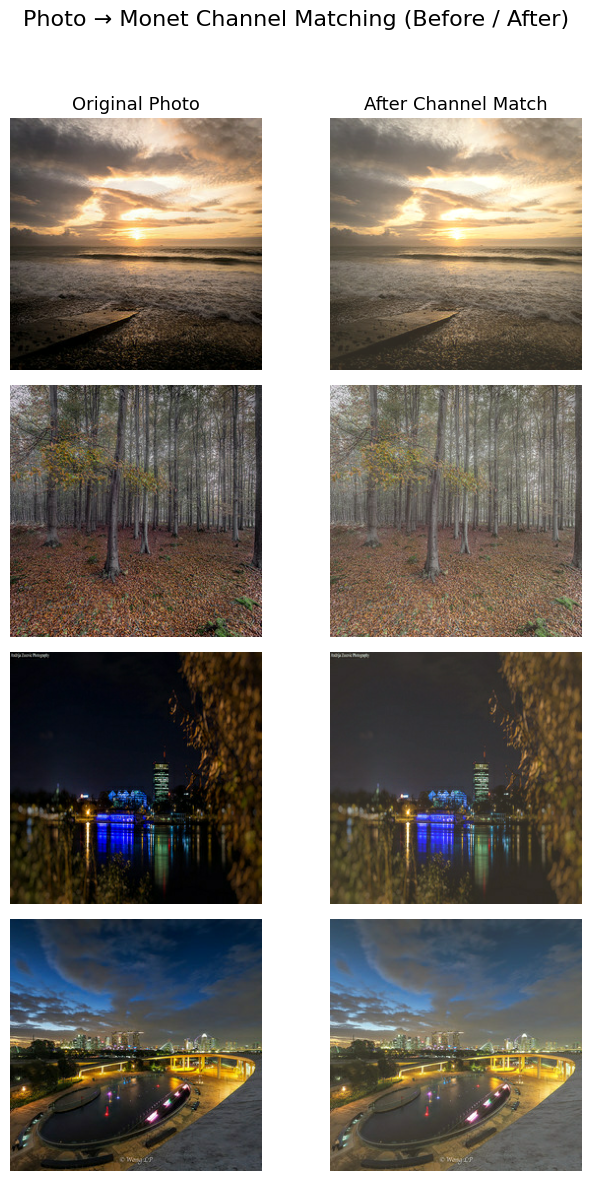

In [10]:
TAKE_FOR_STATS = None  # None = full dataset

def compute_channel_stats(ds, take=None):
    total = 0
    s  = np.zeros(3, dtype=np.float64)
    s2 = np.zeros(3, dtype=np.float64)
    it = ds if take is None else ds.take(take)
    for img in it:
        x = img.numpy().reshape(-1, 3).astype(np.float64)  # [-1,1]
        s  += x.sum(axis=0)
        s2 += np.square(x).sum(axis=0)
        total += x.shape[0]
    mean = s / total
    var  = s2 / total - np.square(mean)
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

def build_channel_matcher(src_mean, src_std, tgt_mean, tgt_std):
    scale = (tgt_std / np.maximum(src_std, 1e-8)).astype(np.float32)
    shift = (tgt_mean - src_mean * scale).astype(np.float32)
    scale_tf = tf.constant(scale, dtype=tf.float32)
    shift_tf = tf.constant(shift, dtype=tf.float32)
    def preprocess(img):
        y = img * scale_tf + shift_tf
        return tf.clip_by_value(y, -1.0, 1.0)
    return preprocess, scale, shift

def show_before_after(ds, preprocess_fn, n_examples=4, seed=42,
                      left_title="Original Photo", right_title="After Channel Match"):
    rng = np.random.default_rng(seed)
    paired = tf.data.Dataset.zip((ds, ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE))).prefetch(AUTOTUNE)
    samples = list(paired.take(64))
    picks = [samples[i] for i in rng.choice(len(samples), size=n_examples, replace=False)]

    fig, axes = plt.subplots(n_examples, 2, figsize=(7, 3*n_examples))
    fig.suptitle("Photo → Monet Channel Matching (Before / After)", fontsize=16)
    for i, (img_orig, img_proc) in enumerate(picks):
        for col, (img, title) in enumerate([(img_orig, left_title), (img_proc, right_title)]):
            x = ((img.numpy() + 1.0) * 0.5)
            axes[i, col].imshow(np.clip(x, 0, 1))
            axes[i, col].axis("off")
            if i == 0: axes[i, col].set_title(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# Compute stats & preview
photo_mean, photo_std = compute_channel_stats(photo_ds, TAKE_FOR_STATS)
monet_mean, monet_std = compute_channel_stats(monet_ds, TAKE_FOR_STATS)
print("Photo  mean/std:", photo_mean, photo_std)
print("Monet  mean/std:", monet_mean, monet_std)

preprocess_photo_to_monet, scale_vec, shift_vec = build_channel_matcher(
    photo_mean, photo_std, monet_mean, monet_std
)
print("Channel-match scale:", scale_vec, "shift:", shift_vec)

show_before_after(photo_ds, preprocess_photo_to_monet, n_examples=4)